In [3]:
"""
NH₃ K-Fold Cross-Validation Results Reader
============================================

Read and visualize k-fold cross-validation results from NH₃ QML comparison.

This plotter provides:
- Per-fold performance visualization
- Box plots for variance comparison
- Coefficient of variation (generalizability metric)
- Learning curves across folds
- Statistical significance analysis

Usage (command line):
    python read_kfold_results_nh3.py kfold_results --plot all --save_dir figures

Usage (Jupyter):
    from read_kfold_results_nh3 import main, KFoldResultsReader
    reader = main('kfold_results', plot='all', save_dir='figures')
"""

import numpy as np
import json
import os
import argparse
import matplotlib.pyplot as plt
from scipy import stats


class KFoldResultsReader:
    """Read and analyze k-fold cross-validation results."""
    
    # Method configuration
    METHODS = [
        "rotationally_equivariant",
        "non_equivariant",
        "graph_permutation_equivariant",
        "classical_equivariant"
    ]
    
    METHOD_LABELS = {
        "rotationally_equivariant": "Rot. Equiv. QML",
        "non_equivariant": "Non-Equiv. QML",
        "graph_permutation_equivariant": "Graph Perm. QML",
        "classical_equivariant": "Classical Equiv. NN"
    }
    
    METHOD_COLORS = {
        "rotationally_equivariant": "#2ecc71",
        "non_equivariant": "#e74c3c",
        "graph_permutation_equivariant": "#3498db",
        "classical_equivariant": "#9b59b6"
    }
    
    def __init__(self, results_dir):
        """
        Initialize reader.
        
        Args:
            results_dir: Directory containing kfold_results.json
        """
        self.results_dir = results_dir
        self.results = None
        self.metrics = None
        
        self._load_results()
        self._detect_methods()
    
    def _load_results(self):
        """Load results from JSON and NPZ files."""
        json_path = os.path.join(self.results_dir, "kfold_results.json")
        npz_path = os.path.join(self.results_dir, "kfold_metrics.npz")
        
        if os.path.exists(json_path):
            with open(json_path, "r") as f:
                self.results = json.load(f)
            print(f"  ✓ Loaded kfold_results.json")
        else:
            print(f"  Warning: {json_path} not found")
        
        if os.path.exists(npz_path):
            self.metrics = dict(np.load(npz_path))
            print(f"  ✓ Loaded kfold_metrics.npz")
        else:
            print(f"  Warning: {npz_path} not found")
    
    def _detect_methods(self):
        """Detect available methods in results."""
        if not self.results:
            self.available_methods = []
            return
        
        self.available_methods = []
        for method in self.METHODS:
            if method in self.results and self.results[method].get("folds"):
                self.available_methods.append(method)
        
        print(f"  ✓ Detected {len(self.available_methods)} methods")
    
    def print_summary(self):
        """Print comprehensive summary statistics."""
        if not self.results:
            print("No results loaded")
            return
        
        config = self.results.get("config", {})
        
        print(f"\n{'='*100}")
        print("NH₃ K-FOLD CROSS-VALIDATION SUMMARY")
        print(f"{'='*100}")
        print(f"\nExperiment Configuration:")
        print(f"  K-Folds: {config.get('k_folds', 'N/A')}")
        print(f"  Epochs per fold: {config.get('n_epochs', 'N/A')}")
        print(f"  Total samples: {config.get('n_samples', 'N/A')}")
        print(f"  Seed: {config.get('seed', 'N/A')}")
        print(f"  Timestamp: {config.get('timestamp', 'N/A')}")
        
        # Summary table
        print(f"\n{'-'*100}")
        print(f"{'Method':<30} {'E_R² (mean±std)':<22} {'F_R² (mean±std)':<22} {'E_CV':<12} {'F_CV':<12}")
        print(f"{'-'*100}")
        
        for method in self.available_methods:
            summary = self.results[method]["summary"]
            e_r2 = summary["E_r2"]
            f_r2 = summary["F_r2"]
            e_cv = summary.get("E_r2_cv", 0)
            f_cv = summary.get("F_r2_cv", 0)
            
            print(f"{self.METHOD_LABELS[method]:<30} "
                  f"{e_r2['mean']:.4f} ± {e_r2['std']:.4f}        "
                  f"{f_r2['mean']:.4f} ± {f_r2['std']:.4f}        "
                  f"{e_cv:.4f}       {f_cv:.4f}")
        
        print(f"{'-'*100}")
        print("CV = Coefficient of Variation (std/mean) - lower values indicate better generalizability")
        
        # Per-fold breakdown
        print(f"\n{'='*100}")
        print("PER-FOLD BREAKDOWN")
        print(f"{'='*100}")
        
        k_folds = config.get('k_folds', 5)
        
        for metric, label in [("E_r2", "Energy R²"), ("F_r2", "Force R²")]:
            print(f"\n{label}:")
            print(f"  {'Method':<30} " + " ".join([f"Fold {i+1:<5}" for i in range(k_folds)]) + f" {'Range':<12}")
            print(f"  {'-'*90}")
            
            for method in self.available_methods:
                values = self.results[method]["summary"][metric]["values"]
                row = f"  {self.METHOD_LABELS[method]:<30} "
                row += " ".join([f"{v:.4f} " for v in values])
                row += f" [{min(values):.3f}-{max(values):.3f}]"
                print(row)
        
        print(f"\n{'='*100}")
    
    def plot_boxplots(self, save_path=None, show=True):
        """Create box plots comparing variance across methods."""
        if not self.results:
            return None
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Prepare data
        metrics = ["E_r2", "F_r2"]
        titles = ["Energy R² Distribution", "Force R² Distribution"]
        
        for ax, metric, title in zip(axes, metrics, titles):
            data = []
            positions = []
            colors = []
            
            for i, method in enumerate(self.available_methods):
                values = self.results[method]["summary"][metric]["values"]
                data.append(values)
                positions.append(i)
                colors.append(self.METHOD_COLORS[method])
            
            bp = ax.boxplot(data, positions=positions, patch_artist=True, widths=0.6)
            
            # Color the boxes
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            # Add scatter points for individual folds
            for i, (method, vals) in enumerate(zip(self.available_methods, data)):
                x = np.random.normal(i, 0.04, len(vals))
                ax.scatter(x, vals, c=self.METHOD_COLORS[method], alpha=0.8, 
                          s=50, edgecolors='black', linewidth=0.5, zorder=5)
            
            ax.set_xticks(positions)
            ax.set_xticklabels([self.METHOD_LABELS[m] for m in self.available_methods],
                              fontsize=10, rotation=15, ha='right')
            ax.set_ylabel('R² Score', fontsize=12)
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='y')
            ax.set_ylim([min(0, min(min(d) for d in data) - 0.1), 1.1])
            ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
        
        plt.suptitle("K-Fold Cross-Validation: Method Comparison", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_fold_performance(self, save_path=None, show=True):
        """Plot per-fold performance for each method."""
        if not self.results:
            return None
        
        k_folds = self.results["config"]["k_folds"]
        folds = np.arange(1, k_folds + 1)
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Energy R² per fold
        ax = axes[0, 0]
        for method in self.available_methods:
            values = self.results[method]["summary"]["E_r2"]["values"]
            ax.plot(folds, values, 'o-', color=self.METHOD_COLORS[method],
                   label=self.METHOD_LABELS[method], linewidth=2, markersize=8)
        ax.set_xlabel('Fold', fontsize=12)
        ax.set_ylabel('Energy R²', fontsize=12)
        ax.set_title('Energy R² by Fold', fontsize=14, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xticks(folds)
        ax.set_ylim([0, 1.1])
        
        # Force R² per fold
        ax = axes[0, 1]
        for method in self.available_methods:
            values = self.results[method]["summary"]["F_r2"]["values"]
            ax.plot(folds, values, 'o-', color=self.METHOD_COLORS[method],
                   label=self.METHOD_LABELS[method], linewidth=2, markersize=8)
        ax.set_xlabel('Fold', fontsize=12)
        ax.set_ylabel('Force R²', fontsize=12)
        ax.set_title('Force R² by Fold', fontsize=14, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xticks(folds)
        
        # Energy MAE per fold
        ax = axes[1, 0]
        for method in self.available_methods:
            values = np.array(self.results[method]["summary"]["E_mae_Ha"]["values"]) * 1000  # mHa
            ax.plot(folds, values, 'o-', color=self.METHOD_COLORS[method],
                   label=self.METHOD_LABELS[method], linewidth=2, markersize=8)
        ax.set_xlabel('Fold', fontsize=12)
        ax.set_ylabel('Energy MAE (mHa)', fontsize=12)
        ax.set_title('Energy MAE by Fold', fontsize=14, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xticks(folds)
        
        # Force MAE per fold
        ax = axes[1, 1]
        for method in self.available_methods:
            values = self.results[method]["summary"]["F_mae"]["values"]
            ax.plot(folds, values, 'o-', color=self.METHOD_COLORS[method],
                   label=self.METHOD_LABELS[method], linewidth=2, markersize=8)
        ax.set_xlabel('Fold', fontsize=12)
        ax.set_ylabel('Force MAE (eV/Å)', fontsize=12)
        ax.set_title('Force MAE by Fold', fontsize=14, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xticks(folds)
        
        plt.suptitle("NH₃ K-Fold CV: Per-Fold Performance", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_generalizability(self, save_path=None, show=True):
        """Plot generalizability metrics (CV, variance)."""
        if not self.results:
            return None
        
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        
        n_methods = len(self.available_methods)
        x = np.arange(n_methods)
        colors = [self.METHOD_COLORS[m] for m in self.available_methods]
        
        # Plot 1: Coefficient of Variation
        ax = axes[0]
        e_cv = [self.results[m]["summary"].get("E_r2_cv", 0) for m in self.available_methods]
        f_cv = [self.results[m]["summary"].get("F_r2_cv", 0) for m in self.available_methods]
        
        width = 0.35
        bars1 = ax.bar(x - width/2, e_cv, width, color='steelblue', alpha=0.8, label='Energy R² CV')
        bars2 = ax.bar(x + width/2, f_cv, width, color='coral', alpha=0.8, label='Force R² CV')
        
        ax.set_xticks(x)
        ax.set_xticklabels([self.METHOD_LABELS[m] for m in self.available_methods],
                          fontsize=9, rotation=15, ha='right')
        ax.set_ylabel('Coefficient of Variation', fontsize=12)
        ax.set_title('Generalizability: CV', fontsize=14, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height < 10:  # Don't label extreme values
                    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                           f'{height:.3f}', ha='center', va='bottom', fontsize=8)
        
        # Plot 2: Standard Deviation
        ax = axes[1]
        e_std = [self.results[m]["summary"]["E_r2"]["std"] for m in self.available_methods]
        f_std = [self.results[m]["summary"]["F_r2"]["std"] for m in self.available_methods]
        
        bars1 = ax.bar(x - width/2, e_std, width, color='steelblue', alpha=0.8, label='Energy R² Std')
        bars2 = ax.bar(x + width/2, f_std, width, color='coral', alpha=0.8, label='Force R² Std')
        
        ax.set_xticks(x)
        ax.set_xticklabels([self.METHOD_LABELS[m] for m in self.available_methods],
                          fontsize=9, rotation=15, ha='right')
        ax.set_ylabel('Standard Deviation', fontsize=12)
        ax.set_title('Consistency: Std Dev ', fontsize=14, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')
        
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.005,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)
        
        # Plot 3: Range (max - min)
        ax = axes[2]
        e_range = [self.results[m]["summary"]["E_r2"]["max"] - self.results[m]["summary"]["E_r2"]["min"] 
                   for m in self.available_methods]
        f_range = [self.results[m]["summary"]["F_r2"]["max"] - self.results[m]["summary"]["F_r2"]["min"] 
                   for m in self.available_methods]
        
        bars1 = ax.bar(x - width/2, e_range, width, color='steelblue', alpha=0.8, label='Energy R² Range')
        bars2 = ax.bar(x + width/2, f_range, width, color='coral', alpha=0.8, label='Force R² Range')
        
        ax.set_xticks(x)
        ax.set_xticklabels([self.METHOD_LABELS[m] for m in self.available_methods],
                          fontsize=9, rotation=15, ha='right')
        ax.set_ylabel('Range (max - min)', fontsize=12)
        ax.set_title('Stability: Range ', fontsize=14, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')
        
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)
        
        plt.suptitle("NH₃ K-Fold CV: Generalizability Metrics", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_mean_std_bars(self, save_path=None, show=True):
        """Create bar chart with mean ± std for all methods."""
        if not self.results:
            return None
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        n_methods = len(self.available_methods)
        x = np.arange(n_methods)
        colors = [self.METHOD_COLORS[m] for m in self.available_methods]
        
        # Energy R²
        ax = axes[0]
        means = [self.results[m]["summary"]["E_r2"]["mean"] for m in self.available_methods]
        stds = [self.results[m]["summary"]["E_r2"]["std"] for m in self.available_methods]
        
        bars = ax.bar(x, means, yerr=stds, color=colors, capsize=8, alpha=0.8,
                     edgecolor='black', linewidth=1.5, error_kw={'linewidth': 2})
        
        ax.set_xticks(x)
        ax.set_xticklabels([self.METHOD_LABELS[m] for m in self.available_methods],
                          fontsize=10, rotation=15, ha='right')
        ax.set_ylabel('R² Score', fontsize=12)
        ax.set_title('Energy R² (mean ± std)', fontsize=14, fontweight='bold')
        ax.set_ylim([0, 1.15])
        ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3, axis='y')
        
        for bar, mean, std in zip(bars, means, stds):
            ax.text(bar.get_x() + bar.get_width()/2, mean + std + 0.03,
                   f'{mean:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Force R²
        ax = axes[1]
        means = [self.results[m]["summary"]["F_r2"]["mean"] for m in self.available_methods]
        stds = [self.results[m]["summary"]["F_r2"]["std"] for m in self.available_methods]
        
        bars = ax.bar(x, means, yerr=stds, color=colors, capsize=8, alpha=0.8,
                     edgecolor='black', linewidth=1.5, error_kw={'linewidth': 2})
        
        ax.set_xticks(x)
        ax.set_xticklabels([self.METHOD_LABELS[m] for m in self.available_methods],
                          fontsize=10, rotation=15, ha='right')
        ax.set_ylabel('R² Score', fontsize=12)
        ax.set_title('Force R² (mean ± std)', fontsize=14, fontweight='bold')
        ax.set_ylim([min(0, min(means) - max(stds) - 0.1), 1.15])
        ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3, axis='y')
        
        for bar, mean, std in zip(bars, means, stds):
            height = max(0, mean + std + 0.03)
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{mean:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.suptitle("NH₃ K-Fold CV: Mean Performance with Error Bars", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_radar(self, save_path=None, show=True):
        """Create radar chart for multi-metric comparison."""
        if not self.results:
            return None
        
        # Metrics to include (normalized so higher is better)
        metrics_config = {
            "E_r2_mean": {"source": ("E_r2", "mean"), "higher_better": True},
            "F_r2_mean": {"source": ("F_r2", "mean"), "higher_better": True},
            "E_consistency": {"source": ("E_r2", "std"), "higher_better": False},
            "F_consistency": {"source": ("F_r2", "std"), "higher_better": False},
            "E_stability": {"source": ("E_r2", "range"), "higher_better": False},
        }
        
        # Collect and normalize values
        values = {m: [] for m in self.available_methods}
        
        for metric_name, config in metrics_config.items():
            source = config["source"]
            all_vals = []
            
            for method in self.available_methods:
                if source[1] == "range":
                    val = self.results[method]["summary"][source[0]]["max"] - \
                          self.results[method]["summary"][source[0]]["min"]
                else:
                    val = self.results[method]["summary"][source[0]][source[1]]
                all_vals.append(val)
            
            # Normalize to [0, 1]
            min_val, max_val = min(all_vals), max(all_vals)
            range_val = max_val - min_val if max_val != min_val else 1
            
            for i, method in enumerate(self.available_methods):
                normalized = (all_vals[i] - min_val) / range_val
                if not config["higher_better"]:
                    normalized = 1 - normalized
                values[method].append(normalized)
        
        # Create radar chart
        labels = ["E R² (mean)", "F R² (mean)", "E Consistency", "F Consistency", "E Stability"]
        num_vars = len(labels)
        
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]
        
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
        
        for method in self.available_methods:
            vals = values[method] + values[method][:1]
            color = self.METHOD_COLORS[method]
            label = self.METHOD_LABELS[method]
            
            ax.plot(angles, vals, 'o-', linewidth=2, label=label, color=color)
            ax.fill(angles, vals, alpha=0.15, color=color)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels, fontsize=11)
        ax.set_ylim(0, 1)
        ax.set_title('NH₃ K-Fold CV: Multi-Metric Comparison', 
                     fontsize=14, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_statistical_significance(self, save_path=None, show=True):
        """Plot statistical significance tests between methods."""
        if not self.results:
            return None
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        n_methods = len(self.available_methods)
        
        for ax, metric, title in zip(axes, ["E_r2", "F_r2"], ["Energy R²", "Force R²"]):
            # Create p-value matrix
            p_matrix = np.ones((n_methods, n_methods))
            
            for i, m1 in enumerate(self.available_methods):
                for j, m2 in enumerate(self.available_methods):
                    if i != j:
                        v1 = self.results[m1]["summary"][metric]["values"]
                        v2 = self.results[m2]["summary"][metric]["values"]
                        
                        # Paired t-test (same folds)
                        try:
                            _, p_val = stats.ttest_rel(v1, v2)
                            p_matrix[i, j] = p_val
                        except:
                            p_matrix[i, j] = 1.0
            
            # Plot heatmap
            im = ax.imshow(p_matrix, cmap='RdYlGn_r', vmin=0, vmax=0.1)
            
            ax.set_xticks(range(n_methods))
            ax.set_yticks(range(n_methods))
            ax.set_xticklabels([self.METHOD_LABELS[m] for m in self.available_methods],
                              fontsize=9, rotation=45, ha='right')
            ax.set_yticklabels([self.METHOD_LABELS[m] for m in self.available_methods],
                              fontsize=9)
            
            # Add text annotations
            for i in range(n_methods):
                for j in range(n_methods):
                    if i != j:
                        p = p_matrix[i, j]
                        text = f'{p:.3f}'
                        if p < 0.05:
                            text += '*'
                        if p < 0.01:
                            text += '*'
                        ax.text(j, i, text, ha='center', va='center', fontsize=9,
                               color='white' if p < 0.05 else 'black')
                    else:
                        ax.text(j, i, '-', ha='center', va='center', fontsize=9)
            
            ax.set_title(f'{title}: Paired t-test p-values', fontsize=12, fontweight='bold')
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax, shrink=0.8)
            cbar.set_label('p-value', fontsize=10)
        
        plt.suptitle("Statistical Significance (p < 0.05 = significant difference)", 
                     fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
        
        return fig
    
    def plot_all(self, output_dir=None, show=True):
        """Generate all plots."""
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
        
        plots = {
            "kfold_boxplots.png": self.plot_boxplots,
            "kfold_fold_performance.png": self.plot_fold_performance,
            "kfold_generalizability.png": self.plot_generalizability,
            "kfold_mean_std_bars.png": self.plot_mean_std_bars,
            "kfold_radar.png": self.plot_radar,
            "kfold_significance.png": self.plot_statistical_significance,
        }
        
        for filename, plot_func in plots.items():
            save_path = os.path.join(output_dir, filename) if output_dir else None
            try:
                plot_func(save_path=save_path, show=show)
            except Exception as e:
                print(f"Warning: Could not generate {filename}: {e}")
        
        if output_dir:
            print(f"\nAll plots saved to {output_dir}")
    
    def export_csv(self, output_path):
        """Export summary statistics to CSV."""
        if not self.results:
            return
        
        lines = ["Method,Metric,Mean,Std,Min,Max,CV"]
        
        metrics = ["E_r2", "E_mae_Ha", "F_r2", "F_mae"]
        
        for method in self.available_methods:
            summary = self.results[method]["summary"]
            label = self.METHOD_LABELS[method]
            
            for metric in metrics:
                s = summary[metric]
                cv = summary.get(f"{metric}_cv", s["std"] / abs(s["mean"]) if s["mean"] != 0 else 0)
                line = f"{label},{metric},{s['mean']:.6f},{s['std']:.6f},{s['min']:.6f},{s['max']:.6f},{cv:.6f}"
                lines.append(line)
        
        with open(output_path, 'w') as f:
            f.write('\n'.join(lines))
        
        print(f"CSV exported: {output_path}")
    
    def export_latex_table(self, output_path=None):
        """Export results as LaTeX table."""
        if not self.results:
            return None
        
        k = self.results["config"]["k_folds"]
        
        lines = [
            "\\begin{table}[h]",
            "\\centering",
            f"\\caption{{NH$_3$ {k}-Fold Cross-Validation Results}}",
            "\\label{tab:nh3_kfold}",
            "\\begin{tabular}{l" + "c" * 4 + "}",
            "\\toprule",
            "Method & E $R^2$ & F $R^2$ & E CV & F CV \\\\",
            "\\midrule",
        ]
        
        for method in self.available_methods:
            summary = self.results[method]["summary"]
            e_r2 = summary["E_r2"]
            f_r2 = summary["F_r2"]
            e_cv = summary.get("E_r2_cv", 0)
            f_cv = summary.get("F_r2_cv", 0)
            
            row = f"{self.METHOD_LABELS[method]} & "
            row += f"${e_r2['mean']:.3f} \\pm {e_r2['std']:.3f}$ & "
            row += f"${f_r2['mean']:.3f} \\pm {f_r2['std']:.3f}$ & "
            row += f"{e_cv:.3f} & {f_cv:.3f} \\\\"
            lines.append(row)
        
        lines.extend([
            "\\bottomrule",
            "\\end{tabular}",
            "\\end{table}"
        ])
        
        latex_str = '\n'.join(lines)
        
        if output_path:
            with open(output_path, 'w') as f:
                f.write(latex_str)
            print(f"LaTeX table exported: {output_path}")
        
        return latex_str
    
    def get_best_method(self, metric="E_r2", criterion="mean"):
        """
        Find the best performing method.
        
        Args:
            metric: Metric to compare (E_r2, F_r2, etc.)
            criterion: "mean" for highest mean, "cv" for lowest coefficient of variation
        
        Returns:
            Dictionary with best method info
        """
        if not self.results:
            return None
        
        best_method = None
        best_value = None
        
        for method in self.available_methods:
            if criterion == "mean":
                val = self.results[method]["summary"][metric]["mean"]
                if best_value is None or val > best_value:
                    best_value = val
                    best_method = method
            elif criterion == "cv":
                val = self.results[method]["summary"].get(f"{metric}_cv", float('inf'))
                if best_value is None or val < best_value:
                    best_value = val
                    best_method = method
            elif criterion == "std":
                val = self.results[method]["summary"][metric]["std"]
                if best_value is None or val < best_value:
                    best_value = val
                    best_method = method
        
        return {
            "method": best_method,
            "label": self.METHOD_LABELS[best_method],
            "value": best_value,
            "criterion": criterion
        }


def main(results_dir, plot='all', save_dir=None, csv=None, latex=None, show=True):
    """
    Main function for reading and visualizing k-fold CV results.
    
    Args:
        results_dir: Directory containing kfold_results.json
        plot: Type of plot ('boxplots', 'fold_performance', 'generalizability', 
              'mean_std', 'radar', 'significance', 'all')
        save_dir: Directory to save plots
        csv: Path to export CSV
        latex: Path to export LaTeX table
        show: Whether to display plots
    
    Returns:
        KFoldResultsReader object
    """
    print(f"Loading k-fold results from: {results_dir}")
    reader = KFoldResultsReader(results_dir)
    reader.print_summary()
    
    # Print best methods
    print("\nBest Methods:")
    print(f"  Best E R² (mean): {reader.get_best_method('E_r2', 'mean')['label']}")
    print(f"  Best F R² (mean): {reader.get_best_method('F_r2', 'mean')['label']}")
    print(f"  Most consistent E R² (lowest std): {reader.get_best_method('E_r2', 'std')['label']}")
    print(f"  Most consistent F R² (lowest std): {reader.get_best_method('F_r2', 'std')['label']}")
    
    if csv:
        reader.export_csv(csv)
    
    if latex:
        reader.export_latex_table(latex)
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    plot_funcs = {
        'boxplots': ('kfold_boxplots.png', reader.plot_boxplots),
        'fold_performance': ('kfold_fold_performance.png', reader.plot_fold_performance),
        'generalizability': ('kfold_generalizability.png', reader.plot_generalizability),
        'mean_std': ('kfold_mean_std_bars.png', reader.plot_mean_std_bars),
        'radar': ('kfold_radar.png', reader.plot_radar),
        'significance': ('kfold_significance.png', reader.plot_statistical_significance),
    }
    
    if plot == 'all':
        reader.plot_all(output_dir=save_dir, show=show)
    elif plot in plot_funcs:
        filename, func = plot_funcs[plot]
        path = os.path.join(save_dir, filename) if save_dir else None
        func(save_path=path, show=show)
    
    return reader


if __name__ == "__main__":
    import sys
    
    if 'ipykernel' in sys.modules:
        print("Running in Jupyter. Call main() with parameters:")
        print("  reader = main('kfold_results', plot='all', save_dir='figures')")
        print("\nOr use the class directly:")
        print("  reader = KFoldResultsReader('kfold_results')")
        print("  reader.print_summary()")
        print("  reader.plot_boxplots()")
        print("  reader.plot_generalizability()")
    else:
        parser = argparse.ArgumentParser(description="Read NH₃ K-Fold CV Results")
        parser.add_argument("results_dir", help="Directory containing kfold_results.json")
        parser.add_argument("--plot", choices=['boxplots', 'fold_performance', 'generalizability',
                                               'mean_std', 'radar', 'significance', 'all'],
                           default='all', help="Type of plot")
        parser.add_argument("--save_dir", type=str, help="Directory to save plots")
        parser.add_argument("--csv", type=str, help="Export to CSV")
        parser.add_argument("--latex", type=str, help="Export to LaTeX table")
        parser.add_argument("--no-show", action="store_true", help="Don't display plots")
        
        args = parser.parse_args()
        
        main(
            results_dir=args.results_dir,
            plot=args.plot,
            save_dir=args.save_dir,
            csv=args.csv,
            latex=args.latex,
            show=not args.no_show
        )

Running in Jupyter. Call main() with parameters:
  reader = main('kfold_results', plot='all', save_dir='figures')

Or use the class directly:
  reader = KFoldResultsReader('kfold_results')
  reader.print_summary()
  reader.plot_boxplots()
  reader.plot_generalizability()


Loading k-fold results from: kfold_results
  ✓ Loaded kfold_results.json
  ✓ Loaded kfold_metrics.npz
  ✓ Detected 4 methods

NH₃ K-FOLD CROSS-VALIDATION SUMMARY

Experiment Configuration:
  K-Folds: 5
  Epochs per fold: 300
  Total samples: 2400
  Seed: 42
  Timestamp: 2025-12-03T04:08:46.107532

----------------------------------------------------------------------------------------------------
Method                         E_R² (mean±std)        F_R² (mean±std)        E_CV         F_CV        
----------------------------------------------------------------------------------------------------
Rot. Equiv. QML                0.9020 ± 0.0740        0.8495 ± 0.0364        0.0820       0.0429
Non-Equiv. QML                 0.1347 ± 0.0399        0.1785 ± 0.0243        0.2959       0.1361
Graph Perm. QML                0.9300 ± 0.0088        0.9410 ± 0.0077        0.0095       0.0082
Classical Equiv. NN            0.9701 ± 0.0056        0.9510 ± 0.0052        0.0057       0.0055
--------

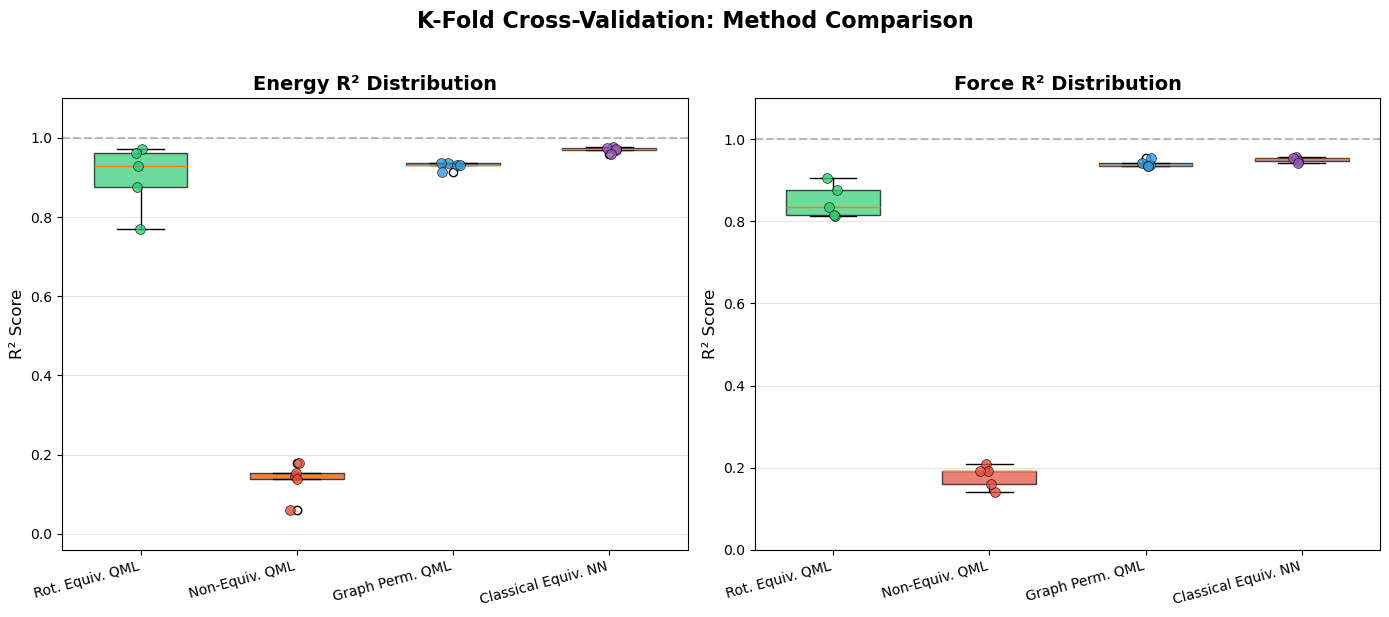

Saved: figures/NH3/kfold_fold_performance.png


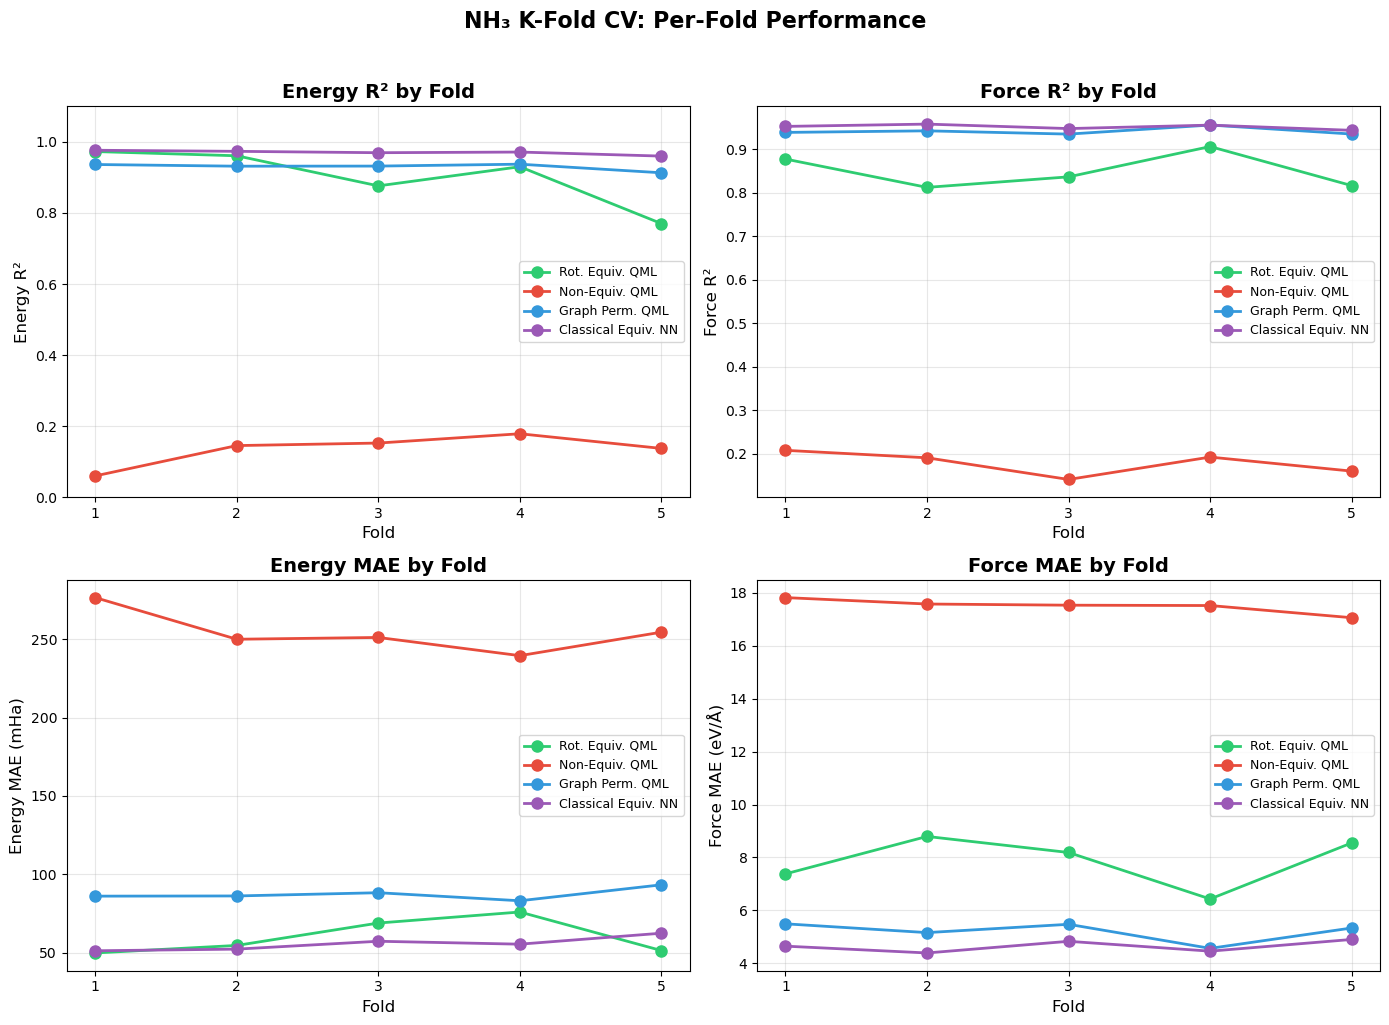

Saved: figures/NH3/kfold_generalizability.png


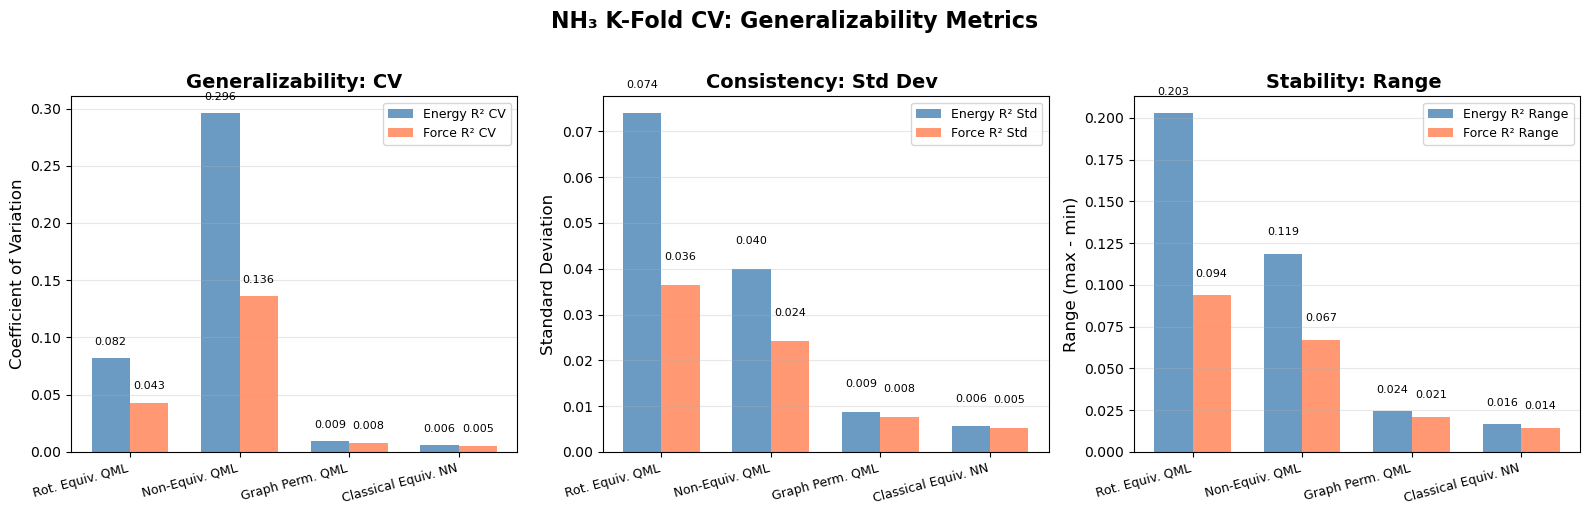

Saved: figures/NH3/kfold_mean_std_bars.png


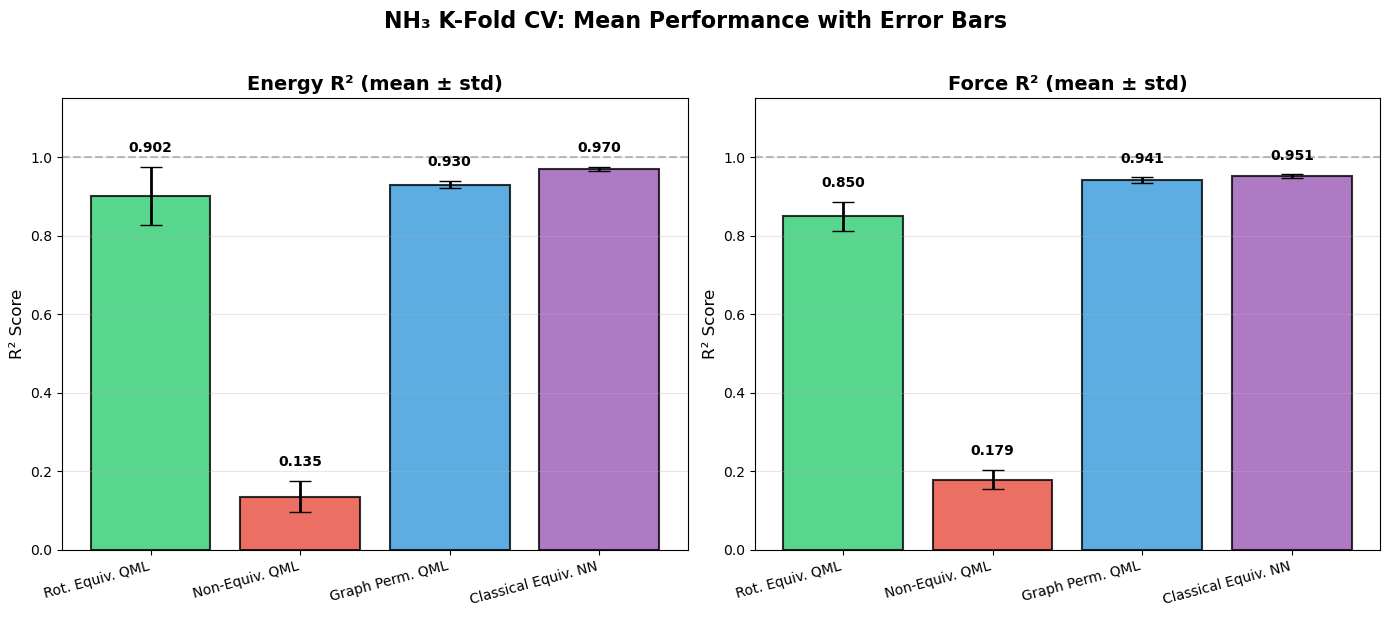

Saved: figures/NH3/kfold_radar.png


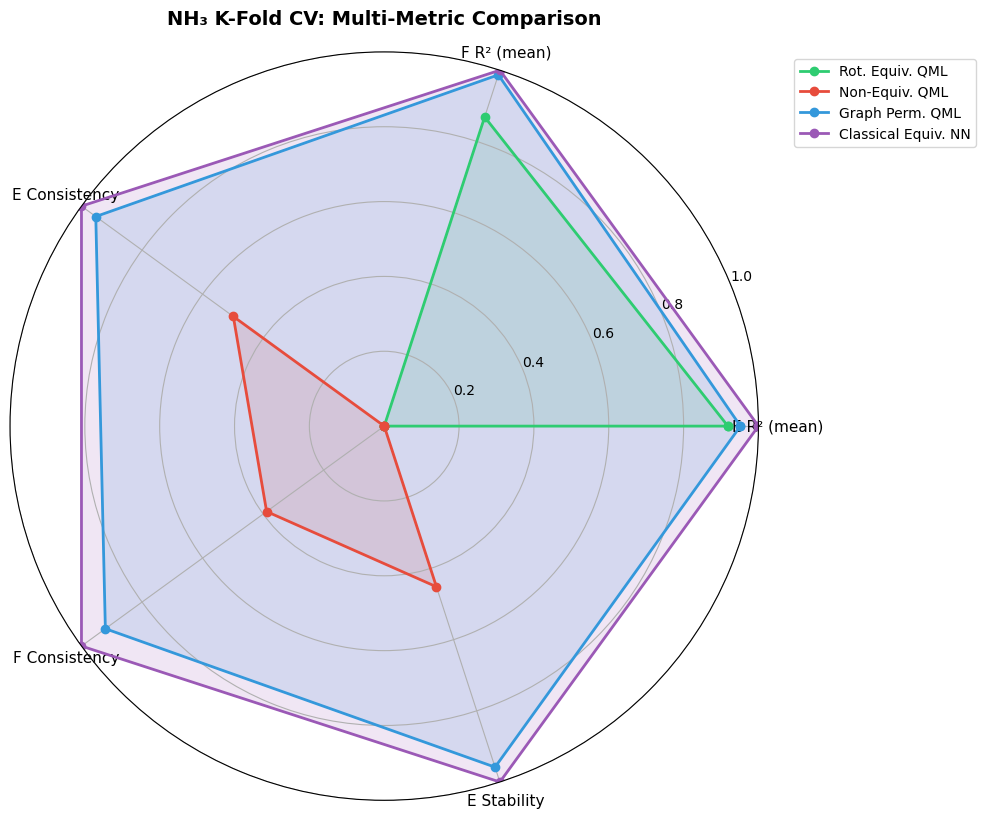

Saved: figures/NH3/kfold_significance.png


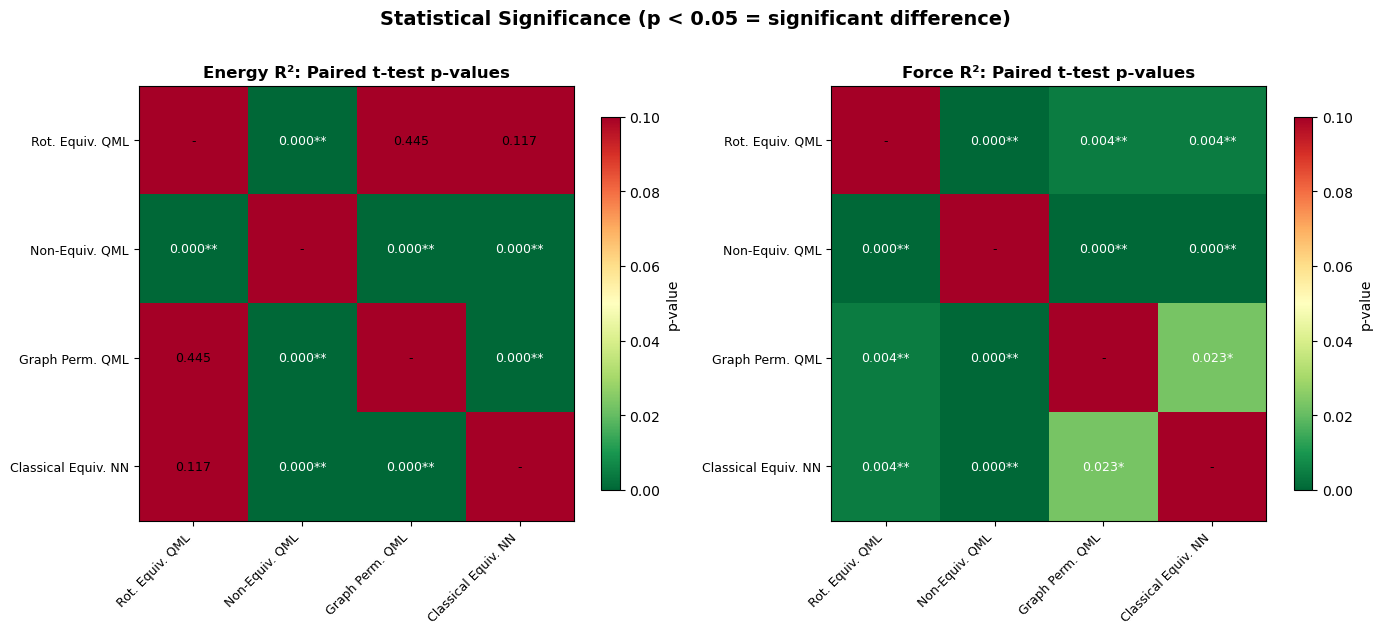


All plots saved to figures/NH3


In [4]:
reader = main('kfold_results', plot='all', save_dir='figures/NH3')